In [9]:
# =============================================================================
# PLANT DISEASE CLASSIFICATION - RESNET50 (Kaggle GPU, Medium Usage)
# Dataset: New Plant Diseases Dataset (Augmented) – same as UmairInayat notebook
# =============================================================================

import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

# =============================================================================
# 1. DEVICE
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))

# =============================================================================
# 2. CORRECT DATA PATHS (YOUR STRUCTURE)
# =============================================================================
root_dir = "/kaggle/input/new-plant-diseases-dataset"

level1_main = "New Plant Diseases Dataset(Augmented)"
level2_main = "New Plant Diseases Dataset(Augmented)"

data_dir = os.path.join(root_dir, level1_main, level2_main)
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")

print("Train dir:", train_dir)
print("Valid dir:", valid_dir)
print("Train exists:", os.path.isdir(train_dir))
print("Valid exists:", os.path.isdir(valid_dir))

# =============================================================================
# 3. DATA TRANSFORMS AND DATALOADERS (MEDIUM GPU USAGE)
# =============================================================================
image_size = 224
batch_size = 32      # reduce to 16 if you get CUDA OOM
num_workers = 2

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2,
                               saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    "valid": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    "train": datasets.ImageFolder(train_dir, data_transforms["train"]),
    "valid": datasets.ImageFolder(valid_dir, data_transforms["valid"]),
}

dataloaders = {
    "train": DataLoader(image_datasets["train"], batch_size=batch_size,
                        shuffle=True, num_workers=num_workers, pin_memory=True),
    "valid": DataLoader(image_datasets["valid"], batch_size=batch_size,
                        shuffle=False, num_workers=num_workers, pin_memory=True),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}
class_names = image_datasets["train"].classes
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Train images: {dataset_sizes['train']}")
print(f"Valid images: {dataset_sizes['valid']}")

# =============================================================================
# 4. MODEL: RESNET50 TRANSFER LEARNING
# =============================================================================
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze backbone for Stage 1
for param in model.parameters():
    param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Optimizer & scheduler for Stage 1 (only classifier head)
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                           factor=0.3, patience=2, verbose=True)

# =============================================================================
# 5. TRAINING FUNCTION
# =============================================================================
def train_model(model, criterion, optimizer, scheduler, num_epochs=6, stage="Stage"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f"\n{stage} - Epoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
                scheduler.step(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

    time_elapsed = time.time() - since
    print(f"\n{stage} complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc in {stage}: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, best_acc, train_losses, train_accs, val_losses, val_accs

# =============================================================================
# 6. STAGE 1 – TRAIN CLASSIFIER ONLY
# =============================================================================
print("\n========== STAGE 1: Classifier head only ==========")
model, best_acc1, tr_l1, tr_a1, va_l1, va_a1 = train_model(
    model, criterion, optimizer, scheduler, num_epochs=6, stage="Stage 1"
)

# =============================================================================
# 7. STAGE 2 – FINE‑TUNE WHOLE MODEL
# =============================================================================
print("\n========== STAGE 2: Fine‑tune all layers ==========")

for param in model.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_ft = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode="min",
                                              factor=0.3, patience=2, verbose=True)

model, best_acc2, tr_l2, tr_a2, va_l2, va_a2 = train_model(
    model, criterion, optimizer_ft, scheduler_ft, num_epochs=6, stage="Stage 2"
)

# =============================================================================
# 8. SAVE MODEL
# =============================================================================
os.makedirs("/kaggle/working/models", exist_ok=True)
model_path = "/kaggle/working/models/resnet50_plant_disease_best.pth"
torch.save(model.state_dict(), model_path)
print(f"\nModel saved to: {model_path}")
print(f"Best validation accuracy overall: {max(best_acc1, best_acc2):.4f}")

# =============================================================================
# 9. (OPTIONAL) SIMPLE TRAINING CURVES
# =============================================================================
# Combine stage metrics if you want to plot later


Using device: cuda
Tesla T4
Train dir: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Valid dir: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
Train exists: True
Valid exists: True
Number of classes: 38
Train images: 70295
Valid images: 17572


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



========== STAGE 1: Classifier head only ==========

Stage 1 - Epoch 1/6
----------------------------------------
Train Loss: 1.2648  Acc: 0.6898
Valid Loss: 0.5247  Acc: 0.8825

Stage 1 - Epoch 2/6
----------------------------------------
Train Loss: 0.8213  Acc: 0.7670
Valid Loss: 0.3743  Acc: 0.9076

Stage 1 - Epoch 3/6
----------------------------------------
Train Loss: 0.7477  Acc: 0.7821
Valid Loss: 0.3205  Acc: 0.9182

Stage 1 - Epoch 4/6
----------------------------------------
Train Loss: 0.7261  Acc: 0.7859
Valid Loss: 0.3007  Acc: 0.9184

Stage 1 - Epoch 5/6
----------------------------------------
Train Loss: 0.7140  Acc: 0.7881
Valid Loss: 0.2772  Acc: 0.9251

Stage 1 - Epoch 6/6
----------------------------------------
Train Loss: 0.6992  Acc: 0.7905
Valid Loss: 0.2814  Acc: 0.9174

Stage 1 complete in 46m 34s
Best val Acc in Stage 1: 0.9251

========== STAGE 2: Fine‑tune all layers ==========

Stage 2 - Epoch 1/6
----------------------------------------
Train Loss: 0.2

In [10]:
# image_datasets["train"].classes already has the class names
classes = image_datasets["train"].classes
print("Number of classes:", len(classes))
print("First 5 classes:", classes[:5])

# Save them to a text file in /kaggle/working
classes_path = "/kaggle/working/classes.txt"
with open(classes_path, "w") as f:
    for c in classes:
        f.write(c + "\n")

print("Saved class names to:", classes_path)


Number of classes: 38
First 5 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']
Saved class names to: /kaggle/working/classes.txt


In [13]:
import pandas as pd

# Stage 1 metrics
stage1_df = pd.DataFrame({
    "train_loss": tr_l1,
    "train_acc":  tr_a1,
    "val_loss":   va_l1,
    "val_acc":    va_a1,
})
stage1_df.index = range(1, len(stage1_df)+1)
stage1_df.index.name = "epoch"

# Stage 2 metrics
stage2_df = pd.DataFrame({
    "train_loss": tr_l2,
    "train_acc":  tr_a2,
    "val_loss":   va_l2,
    "val_acc":    va_a2,
})
stage2_df.index = range(1, len(stage2_df)+1)
stage2_df.index.name = "epoch"

print("Stage 1 metrics:")
display(stage1_df)

print("Stage 2 metrics:")
display(stage2_df)

# Save to CSV so you can download from Kaggle
stage1_df.to_csv("/kaggle/working/stage1_metrics.csv")
stage2_df.to_csv("/kaggle/working/stage2_metrics.csv")
print("Saved CSVs in /kaggle/working")


Stage 1 metrics:


,train_loss,train_acc,val_loss,val_acc
epoch,,,,
1,1.264792,0.689807,0.524666,0.882540
2,0.821327,0.767025,0.374282,0.907637
3,0.747675,0.782076,0.320513,0.918222
4,0.726107,0.785902,0.300736,0.918450
5,0.714016,0.788150,0.277193,0.925051
6,0.699237,0.790469,0.281449,0.917369


Stage 2 metrics:


,train_loss,train_acc,val_loss,val_acc
epoch,,,,
1,0.289274,0.908841,0.037659,0.986911
2,0.174585,0.944235,0.029749,0.990269
3,0.146809,0.953240,0.020341,0.993626
4,0.129536,0.958532,0.020394,0.994366
5,0.120693,0.962913,0.016889,0.994252
6,0.112223,0.964820,0.014296,0.995163


Saved CSVs in /kaggle/working


In [14]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in dataloaders["valid"]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

print("Overall accuracy on validation set:",
      (all_preds == all_labels).mean())


Overall accuracy on validation set: 0.9951627589346688


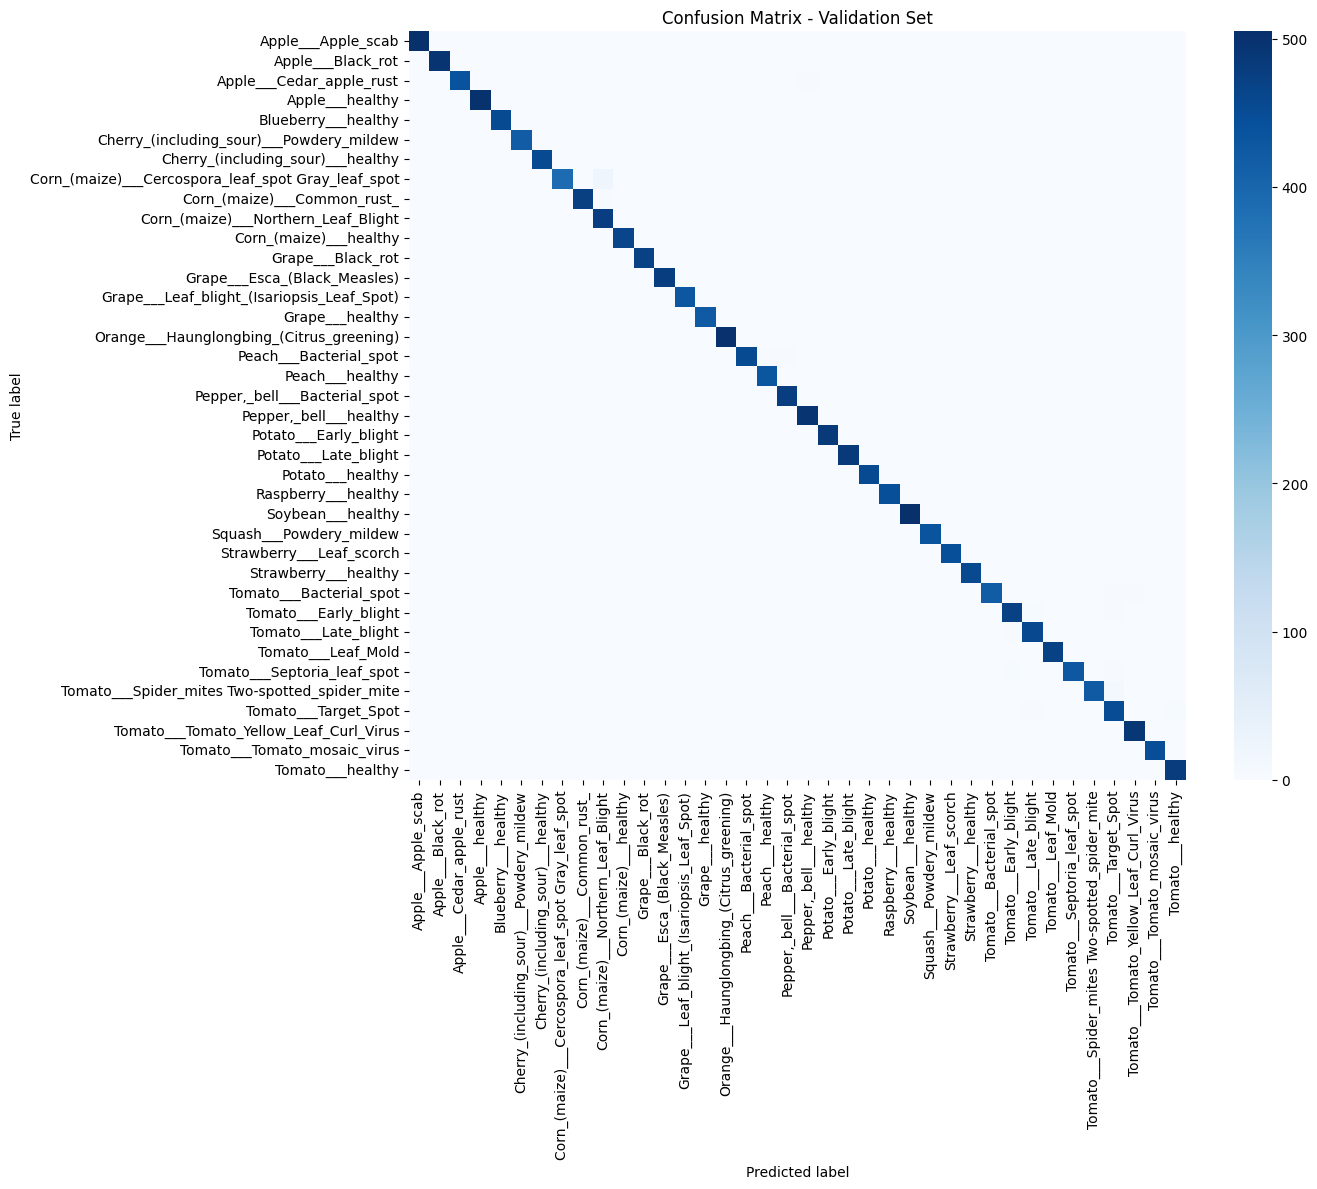

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14, 12))
ax = sns.heatmap(cm,
                 annot=False,
                 cmap="Blues",
                 cbar=True)

# Set tick labels separately
ax.set_xticks(np.arange(len(class_names)) + 0.5)
ax.set_yticks(np.arange(len(class_names)) + 0.5)
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names, rotation=0)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Validation Set")

plt.tight_layout()
plt.savefig("/kaggle/working/confusion_matrix.png", dpi=300)
plt.show()


In [17]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_preds,
                               target_names=class_names,
                               digits=4)
print(report)

# Optional: save to text file
with open("/kaggle/working/classification_report.txt", "w") as f:
    f.write(report)


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9980    1.0000    0.9990       504
                                 Apple___Black_rot     1.0000    1.0000    1.0000       497
                          Apple___Cedar_apple_rust     1.0000    0.9955    0.9977       440
                                   Apple___healthy     1.0000    0.9980    0.9990       502
                               Blueberry___healthy     1.0000    1.0000    1.0000       454
          Cherry_(including_sour)___Powdery_mildew     1.0000    0.9976    0.9988       421
                 Cherry_(including_sour)___healthy     1.0000    0.9978    0.9989       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9974    0.9439    0.9699       410
                       Corn_(maize)___Common_rust_     1.0000    0.9937    0.9968       477
               Corn_(maize)___Northern_Leaf_Blight     0.9482    0.9979    0.97

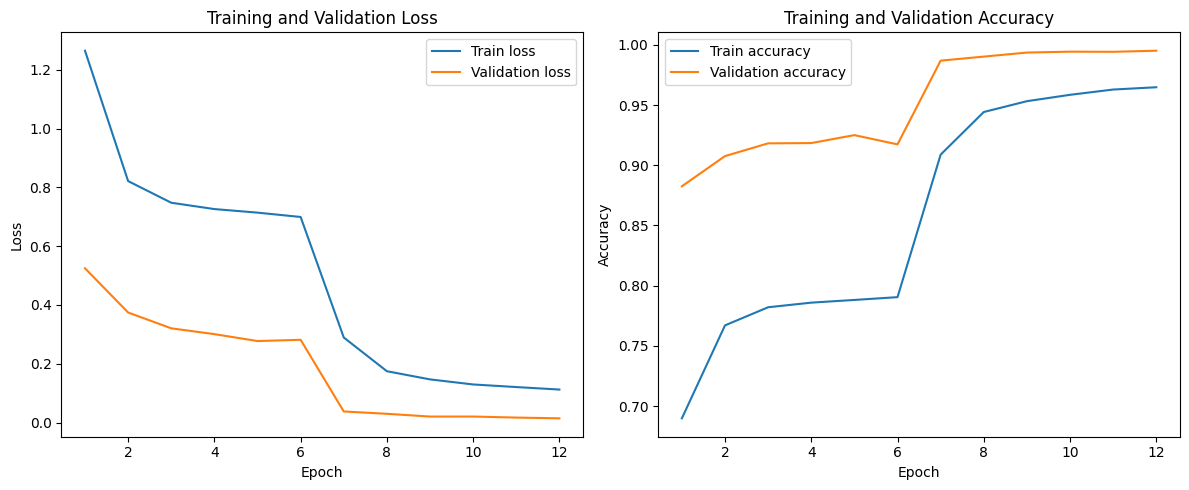

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Combine Stage 1 and Stage 2
train_loss = tr_l1 + tr_l2
val_loss   = va_l1 + va_l2
train_acc  = tr_a1 + tr_a2
val_acc    = va_a1 + va_a2

epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("/kaggle/working/training_curves_full.png", dpi=300)
plt.show()
